# Example result: ball-drop source with rock specimen using OpenSWPC

Some parts of scripts were generated with the assistance of ChatGPT-4 (OpenAI)
Model: GPT-4 (Mini) - Acknowledging the help of AI in generating and improving the code.

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import obspy
from obspy import read, Stream, Trace
from obspy.core.utcdatetime import UTCDateTime  

import xarray as xr
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import pyvista as pv

plt.rcParams["font.family"] = 'Arial'
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75
    
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

UTCDateTime.DEFAULT_PRECISION = 8

# Plot results

## Velocity model for rock specimen

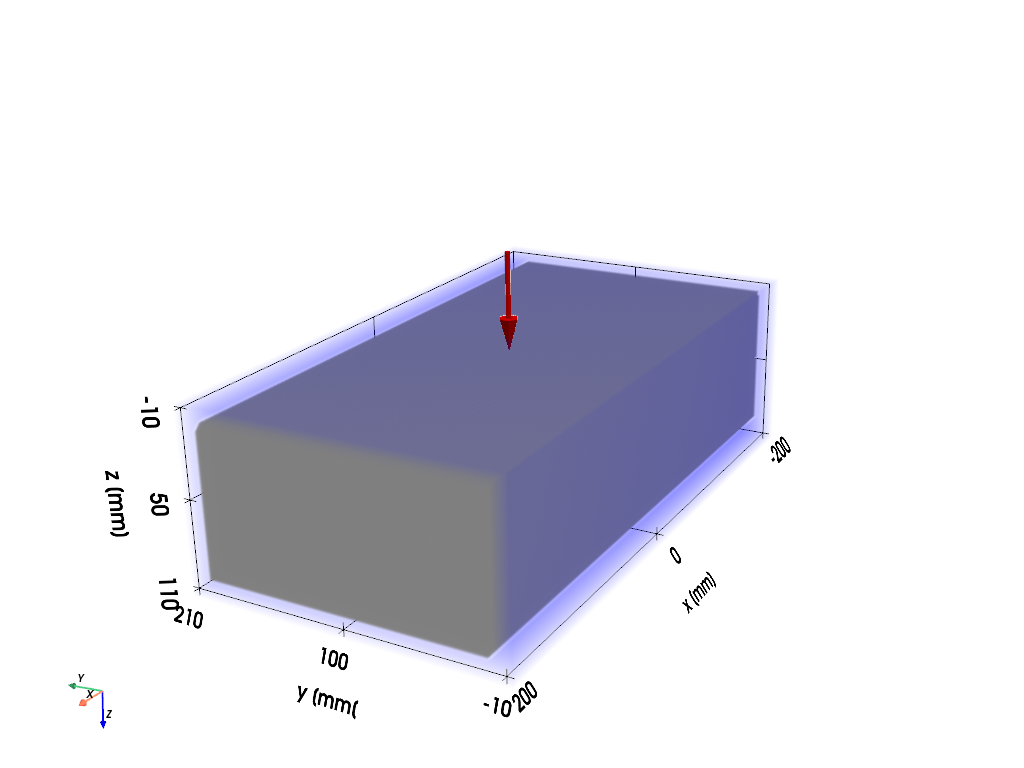

In [2]:
ds = xr.open_dataset("./out/modelparameter.nc")

# Create the meshgrid
x, y, z = np.meshgrid(ds["x"].data*1e6,
                      ds["y"].data*1e6,
                      -ds["z"].data*1e6+100)

downsample_factor = 2

# Slice the arrays to downsample
x_downsampled = x[::downsample_factor, ::downsample_factor, ::downsample_factor]
y_downsampled = y[::downsample_factor, ::downsample_factor, ::downsample_factor]
z_downsampled = z[::downsample_factor, ::downsample_factor, ::downsample_factor]

# Downsample rho data (do not flatten)
rho_downsampled = ds["rho"].data[::downsample_factor, ::downsample_factor, ::downsample_factor]

# Create a StructuredGrid with downsampled data
grid = pv.StructuredGrid(x_downsampled, y_downsampled, z_downsampled)
grid.point_data["rho"] = np.swapaxes(rho_downsampled, 0, 2).flatten()  # swap the array to align the coordinate system

# Plotting the volume
pv.set_jupyter_backend('static')

plotter = pv.Plotter()
sbarargs = dict(title="Density [g/cm^3]\n",
            vertical=True,
            height=0.5,
            label_font_size=12,
            title_font_size=14)

plotter.add_volume(grid, cmap=["blue", "gray"], opacity= [0.01, 0.01, 1], show_scalar_bar=False)
                  # scalar_bar_args=sbarargs)  # Use the 'sigmoid' opacity transfer function

# plotter.add_mesh(grid.outline(), color="black", line_width=1, show_vertices=True)

arrow_c = np.array([0, 100, -70])
arrow_d = np.array([0, 0, 70])
# Define the shaft radius
plotter.add_arrows(arrow_c, arrow_d, mag=1, color="r")

plotter.camera_position = 'yz'
plotter.camera.azimuth = -30  # Rotate around the z-axis
plotter.camera.elevation = -20  # Rotate up/down
plotter.camera.roll = 80  # Roll around the camera view
plotter.show_axes()

gridbounds = [-200, 200, -10, 210, -10, 110]

plotter.show_grid(
    bounds=gridbounds,
    n_xlabels=3,
    n_ylabels=3,
    n_zlabels=3,
    xtitle='x [mm]',
    ytitle='y [mm[',
    ztitle='z [mm]',
    fmt='%.0f',
)

plotter.show()

The example model consists of a 400 x 200 x 100 mm rock specimen, surrounded by a 10 mm air layer shown in blue. PML absorbing boundaries are applied to the side surfaces along the x direction.

**NOTE:**
- This model output is only available when running a simulation with single core. 

## Ball-drop source

We implemented the ball-drop impact source based on the Hertzian impact theory.

References:
1. Reed, J. Energy losses due to elastic wave propagation during an elastic impact. Journal of Physics D: Applied Physics, 18(12):2329--2337, 1985, doi:10.1088/0022-3727/18/12/004.
2. McLaskey, G. C. and Steven D. Glaser. High-fidelity conical piezoelectric transducers and finite element models utilized to quantify elastic waves generated from ball collisions. In Sensors and Smart Structures Technologies for Civil, Mechanical, and Aerospace Systems 2009, volume 7292, 264 -- 271, International Society for Optics and Photonics, SPIE, 2009.
3. McLaskey, G. C. and Glaser, S. D. Acoustic Emission Sensor Calibration for Absolute Source Measurements. J. Nondestruct. Eval., 31(2):157--168, 2012, doi:10.1007/s10921-012-0131-2.


In this example, we drop the ball from a height of 0.5 m above the rock surface. This scenario is analogous to Lamb's problem.


In [3]:
def stf_herzian_mclaskey2009(t, rho, R, v, E1, nu1, E2, nu2):
    '''
        source time function of Herzian solution
    '''
    def get_delta(E1, mu1, E2, mu2):
        del1 = (1-nu1**2)/(np.pi*E1)
        del2 = (1-nu2**2)/(np.pi*E2)
        return (del1, del2)
    
    
    def get_contact_time(rho, del1, del2, R, v):
        return 4.53*(( 4*rho  * np.pi * (del1 + del2) /3 )**(2/5)) * R * (v **(-1/5))

    def get_maximum_force(rho, del1, del2, R, v):
        return 1.917 * (rho**(3/5)) * ((del1 + del2)**(-2/5)) * (R**2) * (v**(6/5))

        
    del1, del2 = get_delta(E1, nu1, E2, nu2)
        
    tc = get_contact_time(rho, del1, del2, R, v)
    fmax = get_maximum_force(rho, del1, del2, R, v)
    
    stf = np.zeros(len(t))
    for i, tt in enumerate(t):
        if 0<tt and tt < tc:
            stf[i] = fmax*(np.sin(np.pi*tt/tc))**(3/2)
        else:
            stf[i] = 0
            
    return stf, fmax, tc


In [4]:
# Compute force time function of ball-drop
dt = 1e-7
tvec = np.arange(np.ceil(20e-6/dt)) * dt 

In [5]:
h = 0.500 # 0.127 #0.500  # [m] dropped 500mm for tha case of 4m ball drop.
g = 9.80665
v = np.sqrt(2*g*h) # incoming velocity of the ball

# Rock block constants
rho_rock = 2980
cp_rock  = 6200 #6919
cs_rock  = 3600 #3631
vpvs_rock = cp_rock/cs_rock
nu_rock  = 0.5 * (((vpvs_rock**2) - 2.0) / ((vpvs_rock**2) - 1.0))
G_rock = rho_rock * (cs_rock **2) #[Pa]
E_rock = 2.0 * G_rock * (1+nu_rock) # [Pa]

# Young's modulus of rock

ft_herz_mc_4m, fmax, tc = stf_herzian_mclaskey2009(tvec, 7758.8, 1e-3, v, 208.197e9, 0.286, E_rock, nu_rock)

In [6]:
M0scalingfactor = 1.748*fmax*tc/np.pi # See "doc/note_on_Hertzian_impact_source"

In [7]:
# Read the output of numerical simulation
df_source=pd.read_csv("./out/stf_001_000.dat", index_col=0, skipinitialspace=True)

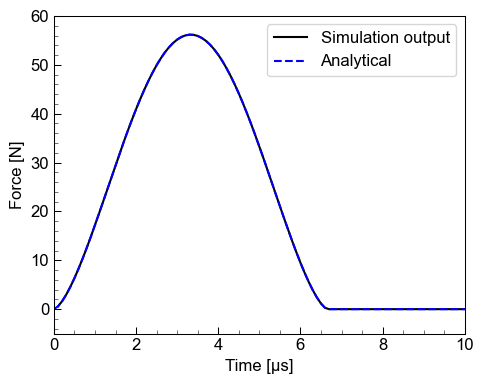

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(df_source.index*1e6, df_source["stf"]*M0scalingfactor, "k-", label="Simulation output")
ax.plot(tvec*1e6, ft_herz_mc_4m, "b--", label="Analytical")

ax.set_xlim([0, 10])
ax.set_ylim([-5, 60])

ax.set_xlabel("Time [μs]")
ax.set_ylabel("Force [N]")
plt.tight_layout()
ax.legend(loc=0)

> We confirmed the simulation output is consistent with the intended force-time function.

## Velocity snapshot

In [9]:
# location of cross-section
z0_xy            =  20      # depth for xy cross section
x0_yz            =  50      # x-value for yz cross section
y0_xz            =  50      # y-value for xz cross section

### xz cross-section

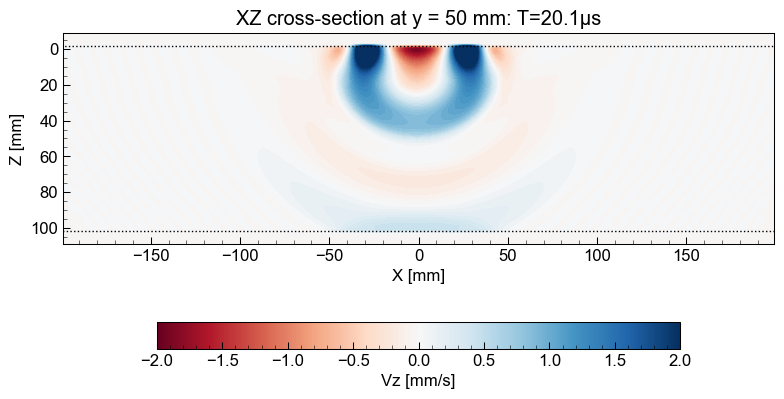

In [10]:
# Step 1: Read the NetCDF data
file_path = "./out/example_balldrop.xz.v.nc"
ds = xr.open_dataset(file_path)

# Step 2: Extract the "Vx" variable and the corresponding coordinates (x, y)
vz_data = ds["Vz"]*1e3  # [mm/s]
tvec = ds["t"]
x_coords = ds["x"]*1e6  # [mm] x-coordinate
z_coords = ds["z"]*1e6  # [mm] z-coordinate

# Plotting the color map
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cmin = -2.0
cmax = 2.0
norm_C = mpl.colors.Normalize(vmin=cmin, vmax=cmax)

tid = 20 # Time index

h=ax.contourf(x_coords, z_coords, vz_data[tid, :, :], 100, norm=norm_C, cmap='RdBu')  # Plot Vx for the first timestep
ax.set_xlabel("X [mm]")
ax.set_ylabel("Z [mm]")

plt.colorbar(mpl.cm.ScalarMappable(norm=h.norm, cmap=h.cmap), ax=ax, 
             orientation="horizontal", fraction=0.05, label="Vz [mm/s]")  # Add a colorbar with label

ax.invert_yaxis()
ax.set_aspect('equal')

plt.tight_layout()

ax.set_title(f"XZ cross-section at y = {y0_xz} mm: T={tvec[tid]*1e6:.1f}μs")

# plot air-solid boundary
grid_space_shift = +2.0 # the surface is alighned with the grid, so shift the lines just for the visualization. 
rect = plt.Rectangle((-200, 0-grid_space_shift), 400, 100+2*grid_space_shift, linewidth=1, edgecolor='black', facecolor='none', ls=":")
ax.add_patch(rect)

>We confirmed no artifacts near the air-solid boundary surrounding the rock specimen (dotted lines).

**NOTE:**
- The grid size in this example is uniformly set to `2.0` mm in all directions.
- The `Wavelength Condition` is not satisfied in this example to reduce computational cost, as this is intended for tutorial purposes. In the main simulation, we set the grid size to 0.5 mm to satisfy the condition."

### xy cross-section

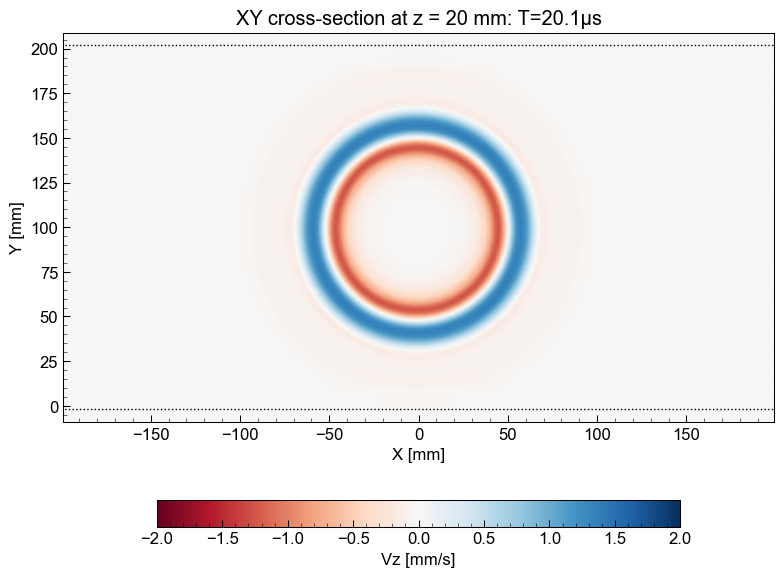

In [11]:
# Step 1: Read the NetCDF data
file_path = "./out/example_balldrop.xy.v.nc"
ds = xr.open_dataset(file_path)

# Step 2: Extract the "Vx" variable and the corresponding coordinates (x, y)
vz_data = ds["Vz"]*1e3  # [mm/s]
tvec = ds["t"]
x_coords = ds["x"]*1e6  # [mm] x-coordinate
y_coords = ds["y"]*1e6  # [mm] z-coordinate

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

h=ax.contourf(x_coords, y_coords, vz_data[tid, :, :], 100, norm=norm_C, cmap='RdBu')  # Plot Vx for the first timestep
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")

plt.colorbar(mpl.cm.ScalarMappable(norm=h.norm, cmap=h.cmap), ax=ax, 
             orientation="horizontal", fraction=0.05, label="Vz [mm/s]")  # Add a colorbar with label

# ax.invert_yaxis()
ax.set_aspect('equal')

plt.tight_layout()

ax.set_title(f"XY cross-section at z = {z0_xy} mm: T={tvec[tid]*1e6:.1f}μs")

# plot air-solid boundary
grid_space_shift = +2.0 # the surface is alighned with the grid, so shift the lines just for the visualization. 
rect = plt.Rectangle((-200, 0-grid_space_shift), 400, 200+2*grid_space_shift, linewidth=1, edgecolor='black', facecolor='none', ls=":")
ax.add_patch(rect)

### yz cross-section

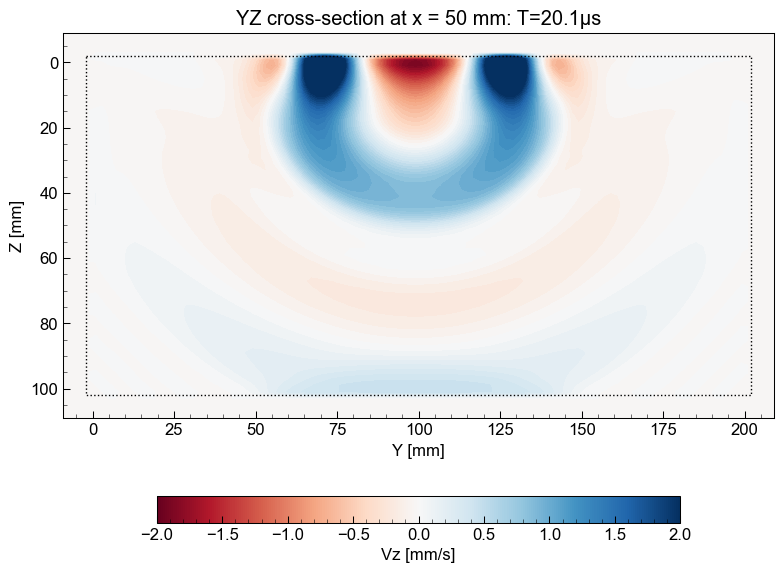

In [12]:
# Step 1: Read the NetCDF data
file_path = "./out/example_balldrop.yz.v.nc"
ds = xr.open_dataset(file_path)

# Step 2: Extract the "Vx" variable and the corresponding coordinates (x, y)
vz_data = ds["Vz"]*1e3  # [mm/s]
tvec = ds["t"]
y_coords = ds["y"]*1e6  # [mm] x-coordinate
z_coords = ds["z"]*1e6  # [mm] z-coordinate

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

h=ax.contourf(y_coords, z_coords, vz_data[tid, :, :].data, 100, norm=norm_C, cmap='RdBu')  # Plot Vx for the first timestep
ax.set_xlabel("Y [mm]")
ax.set_ylabel("Z [mm]")

plt.colorbar(mpl.cm.ScalarMappable(norm=h.norm, cmap=h.cmap), ax=ax, 
             orientation="horizontal", fraction=0.05, label="Vz [mm/s]")  # Add a colorbar with label

ax.invert_yaxis()
ax.set_aspect('equal')

plt.tight_layout()

ax.set_title(f"YZ cross-section at x = {x0_yz} mm: T={tvec[tid]*1e6:.1f}μs")

# plot air-solid boundary
grid_space_shift = +2.0 # the surface is alighned with the grid, so shift the lines just for the visualization. 
rect = plt.Rectangle((0-grid_space_shift, 0-grid_space_shift), 200+2*grid_space_shift, 100+2*grid_space_shift, linewidth=1, edgecolor='black', facecolor='none', ls=":")
ax.add_patch(rect)

# Boundary detection algorithm

The air-solid boundary is identified by extending the original algorithm designed for free-surface and ocean-bottom boundaries.

We first define four reference planes: kfs_biax_upper_top, kfs_biax_upper_bot, kfs_biax_lower_top, and kfs_biax_lower_bot, as illustrated below:

<img src="./OpenSWPC_surface_correction_BIAX.jpg" alt="Surface Detection" width="500px">

Next, we evaluate the differences between these planes to detect the grid points near the boundary, where a second-order approximation is applied.

References:
1. Nakamura, T., Takenaka, H., Okamoto, T., and Kaneda, Y. Fdm simulation of seismic‐wave propagation for an aftershock of the 2009 suruga bay earthquake: effects of ocean‐bottom topography and seawater layer. B. Seismol. Soc. Am., 102(6):2420-2435, 2012, doi:10.1785/0120110356.

2. Maeda, T. and Furumura, T. Fdm simulation of seismic waves, ocean acoustic waves, and tsunamis based on tsunami-coupled equations of motion. Pure. Appl. Geophys., 170(1):109--127, 2013, doi:10.1007/s00024-011-0430-z.

**Simulation Output**

The following figure shows the output of the simulation:

<img src="./kfs_biax.jpg" alt="Simulation Output" width="500px">

# Plot waveforms

We placed the virtual station at (x, y, z) = (100, 70, 99) mm. We set 1 mm inside the rock specimen to ensure it remains within the solid region.

In [13]:
st=read("./out/wav/*.sac")

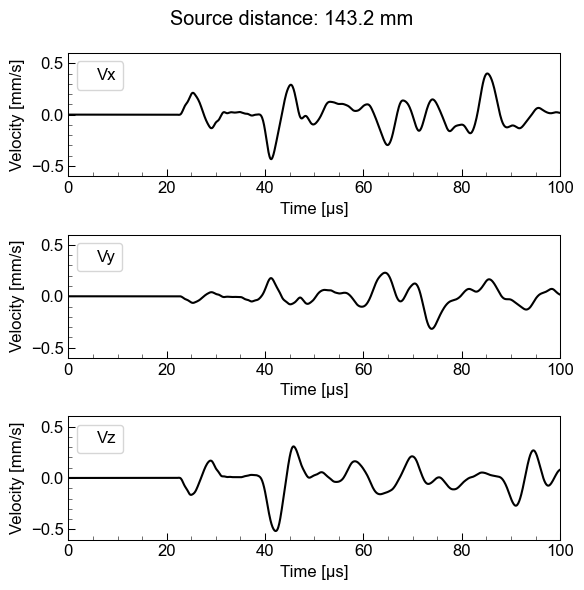

In [14]:
sourceloc = np.array([0, 100, 1])
stationloc = np.array([100, 70, 99])

sourcedist = np.linalg.norm(sourceloc-stationloc)

fig, axs = plt.subplots(3, 1, figsize=(6, 6))

tvec = st[0].times()*1e6
for i, tr in enumerate(st.select(channel="V*")):
    ax = axs[i]
    ax.plot(tvec, tr.data*1e-6, "k-", label=f"{tr.stats.channel}")
    ax.set_xlabel("Time [μs]")
    ax.set_ylabel("Velocity [mm/s]")
    ax.set_xlim([0, 100])
    ax.set_ylim([-0.6, 0.6])
    ax.legend(loc=2, handlelength=0.)

plt.suptitle(f"Source distance: {sourcedist:.1f} mm")
plt.tight_layout()
fig.align_ylabels()